# DIVERS Two Component Variance and Covariance Decomposition

## This workflow is for users interested in separating two different sources of variability in data

## Here we separate biological variability versus technical variability in our fecal time series study (biological variability represents the sum of temporal and spatial variability)

## 1) Read in absolute abundance tables (generated from preprocess_OTU_relative_abundance_table.ipynb) 


In [2]:
%Directory containing absolute abundance tables
file_dir = ['/Path/To/.../absolute_abundances/'];

%data_X (Samples that represent one of the two technical replicates from each time point)
T_X = readtable([file_dir 'data_X.txt'],'Delimiter','\t');
otu_ids = table2array(T_X(:,1));
tax = table2array(T_X(:,end));
data_X = table2array(T_X(:,2:end-1));
[Mx,Nx] = size(data_X);

%data_Y (Samples that represent the second the two technical replicates from each time point)
T_Y = readtable([file_dir 'data_Y.txt'],'Delimiter','\t');
data_Y = table2array(T_Y(:,2:end-1));
[My,Ny] = size(data_Y);



## 2) Calculate marginal (total) mean abundances and abundance variances of each OTU 

In [3]:
marg_means = [];
marg_vars = [];

%Perform 500 different re-sampling iterations
for i = 1:5e2
    
    data_X_perm = [];
    
    %Randomly draw a sample from data_X, data_Y or data_Z
    for j = 1:Nx
        flip = rand;
        if flip > 1/2
            data_X_perm(:,j) = data_X(:,j);
        else
            data_X_perm(:,j) = data_Y(:,j);
        end
    end
    
    %Estimate mean and variance from this iteration
    marg_means(:,i) = mean(data_X_perm,2);
    marg_vars(:,i) = var(data_X_perm')';
end

%Average over all re-sampling iterations
means = mean(marg_means,2);
vars_total = mean(marg_vars,2);


### These are the total abundance variances for every OTU

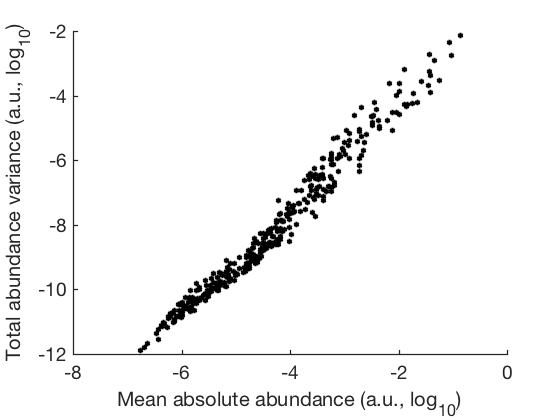

In [4]:
f2 = figure;
p2 = plot(log10(means),log10(vars_total),'ko');
p2.MarkerSize = 3;
p2.MarkerFaceColor = 'k';
xlabel('Mean absolute abundance (a.u., log_{10})')
ylabel('Total abundance variance (a.u., log_{10})')
set(gca,'FontSize',14)
set(gca,'LineWidth',1)
box off

## 3) Variance decomposition of OTU abundances (should take several seconds)


In [8]:
disp(['Performing variance decomposition...'])


covs_XY = [];
vars_XmY = [];

%Perfor 500 re-sampling iterations
for i = 1:5e2

    data_X_perm = [];
    data_Y_perm = [];
    
    %Randomly permute X and Y, Z stays the same
    for j = 1:Nx
        flip = rand;
        if flip > .5
            data_X_perm(:,j) = data_X(:,j);
            data_Y_perm(:,j) = data_Y(:,j);
        else
            data_X_perm(:,j) = data_Y(:,j);
            data_Y_perm(:,j) = data_X(:,j);
        end
    end
    
    %Temporal + spatial variance
    cov_XY = [];
    for j = 1:Mx
        covmat_xy = cov(data_X_perm(j,:),data_Y_perm(j,:));
        cov_xy = covmat_xy(1,2);
        cov_XY(j) = cov_xy;
    end
    covs_XY(:,i) = cov_XY';
     
    %Technical
    var_XmY = .5 * var((data_X_perm - data_Y_perm)')';
    vars_XmY(:,i) = var_XmY;
    
end

%% Average over re-sampling iterations

%Biological variance
vars_B = mean(covs_XY,2);
vars_B = max(vars_B,0); %Ignore negative estimates of variability

%Technical variance
vars_N = mean(vars_XmY,2);

%Fraction of each component to total variance
vf_N = vars_N ./ (vars_N + vars_B);
vf_B = vars_B ./ (vars_N + vars_B);


disp(['Variance decomposition complete!'])



Performing variance decomposition...
Variance decomposition complete!


### We now have the biological and technical variance contributions of every OTU!

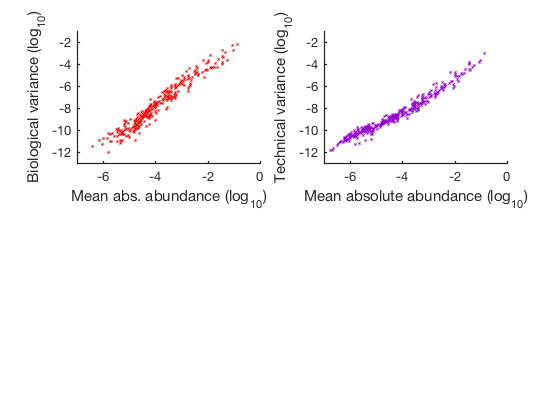

In [9]:
f3 = figure;
addpath('/Path/To/.../matlab_plotting/') %plotting functions
c = @cmu.colors;

subplot(2,2,1)
p3a = plot(log10(means),log10(vars_B),'ro');
p3a.MarkerSize = 1;
p3a.MarkerFaceColor = 'r';
xlabel('Mean abs. abundance (log_{10})')
ylabel('Biological variance (log_{10})')
set(gca,'FontSize',10)
set(gca,'LineWidth',1)
set(gca,'xlim',[-7,0])
set(gca,'ylim',[-13,-1])
box off

subplot(2,2,2)
p3b = plot(log10(means),log10(vars_N),'ko');
p3b.MarkerSize = 1;
p3b.Color = c('dark violet');
p3b.MarkerFaceColor = c('dark violet');
xlabel('Mean absolute abundance (log_{10})')
ylabel('Technical variance (log_{10})')
set(gca,'FontSize',10)
set(gca,'LineWidth',1)
set(gca,'xlim',[-7,0])
set(gca,'ylim',[-13,-1])
box off



## 4) Covariance decomposition of OTU abundances


### a) Calculate total covariances between all OTU pairs

In [10]:
disp(['Calculating total covariances...'])

covs_total = [];

%Perform 500 re-sampling iterations
for i = 1:5e2

    data_X_perm = [];

    %Randomly choose a sample from data_X or data_Y
    for j = 1:Nx
        flip = rand;
        if flip > 1/2
            data_X_perm(:,j) = data_X(:,j);
        else
            data_X_perm(:,j) = data_Y(:,j);
        end
    end
    
    %Mean center the data 
    data_X_mc = data_X_perm - repmat(mean(data_X_perm,2),1,Nx);
    
    %Calculate covariance matrix
    covmat_X_perm = 1/(Nx-1) * data_X_mc * data_X_mc';
    
    %Store covariance matrix for this iteration
    covs_total(:,:,i) = covmat_X_perm;  
    
end
covmat_total = mean(covs_total,3);
clear covs_total;

disp(['Total covariances calculated!'])


Calculating total covariances...
Total covariances calculated!


### b) Calculate biological covariances between all OTU pairs (should take several seconds)

In [11]:
disp(['Calculating biological covariances...'])

crosscovs_B = [];

%Perform 500 re-sampling iterations
for i = 1:5e2

    data_X_perm = [];
    data_Y_perm = [];
    
    %One realization of the data
    for j = 1:Nx
        flip = rand;
        if flip > .5
            data_X_perm(:,j) = data_X(:,j);
            data_Y_perm(:,j) = data_Y(:,j);
        else
            data_X_perm(:,j) = data_Y(:,j);
            data_Y_perm(:,j) = data_X(:,j);
        end
    end
    
    %Mean center matrices;
    data_X_mc = data_X_perm - repmat(mean(data_X_perm,2),1,Nx);
    data_Y_mc = data_Y_perm - repmat(mean(data_Y_perm,2),1,Ny);
    
    %Calculate all pairwise covariances for this realization (2
    %permutations)
    covmat_XY = 1/(Nx-1) * data_X_mc*data_Y_mc'; %(X_i,Y_j)
    covmat_YX = 1/(Nx-1) * data_Y_mc*data_X_mc'; %(Y_i,X_j)
    covmat = 1/2 * (covmat_XY + covmat_YX);
    
    %Store covmat for each realization
    crosscovs_B(:,:,i) = covmat;    

end

%Average over all iterations
covmat_B = mean(crosscovs_B,3);
clear crosscovs_B;

disp(['Biological covariances calculated!'])


Calculating biological covariances...
Temporal covariances calculated!


### c) Calculate technical covariances between all OTU pairs (should take several seconds)

In [12]:
disp(['Calculating technical covariances...'])

crosscovs_N = [];

%Peform 500 re-sampling iterations
for i = 1:5e2

    data_X_perm = [];
    data_Y_perm = [];
    
    %One realization of the data
    for j = 1:Nx
    flip = rand;
        if flip > .5
            data_X_perm(:,j) = data_X(:,j);
            data_Y_perm(:,j) = data_Y(:,j);
        else
            data_X_perm(:,j) = data_Y(:,j);
            data_Y_perm(:,j) = data_X(:,j);
        end
    end
   
    data_XmY = data_X_perm - data_Y_perm;
    
    %Mean center matrices;
    data_XmY_mc = data_XmY - repmat(mean(data_XmY,2),1,Nx);
    
    %Calculate all pairwise covariances for this realization (1
    %permutation)
    covmat = 1/(Nx-1) * data_XmY_mc*data_XmY_mc';
    
    %Store covmat for each realization
    crosscovs_N(:,:,i) = .5 * covmat;   

end

%Average over all iterations
covmat_N = mean(crosscovs_N,3);  
clear crosscovs_N;


disp(['Technical covariances calculated!'])


Calculating technical covariances...
Technical covariances calculated!


## 5) Rescale covariances to obtain correlations

In [13]:
L = length(vars_total);

%Calculate product of marginal standard deviations for each pair of OTUs
sigxsigy = [];
for i = 1:L
   for j = 1:i
       if vars_total(i) > 0 && vars_total(j) > 0
            sigxsigy(i,j) = sqrt(vars_total(i))*sqrt(vars_total(j));
            sigxsigy(j,i) = sqrt(vars_total(i))*sqrt(vars_total(j));
       else
            sigxsigy(i,j) = 0;
            sigxsigy(j,i) = 0;
       end
   end
end

cormat_total = covmat_total ./ sigxsigy;
cormat_B = covmat_B ./ sigxsigy;
cormat_N = covmat_N ./ sigxsigy;




### We now have the temporal, spatial, and technical correlation contributions for all pairs of OTUs!

> In colorGradient (line 32)
> In colorGradient (line 32)


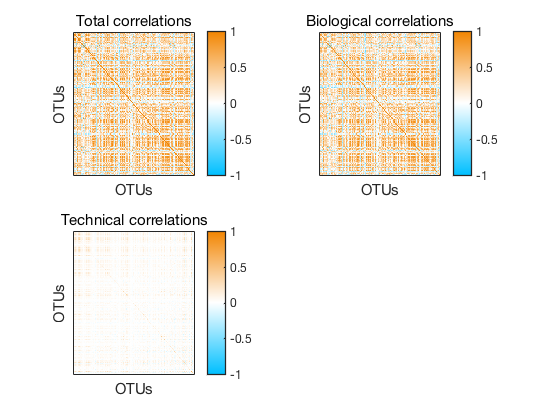

In [14]:
f5 = figure;

cmap1 = colorGradient(c('deep sky blue'),c('white'),500);
cmap2 = colorGradient(c('white'),c('tangerine'),500);
cmap = [cmap1;cmap2];
colormap(cmap);


%Plot the correlation heatmaps

high_inds = find(log10(means) > -4); %Show only abundant OTUs

%Total correlations
subplot(2,2,1)
p5a = imagesc(cormat_total(high_inds,high_inds));
set(gca,'XTick',[])
set(gca,'YTick',[])
xlabel('OTUs')
ylabel('OTUs')
title('Total correlations','FontWeight','Normal')
c5a = colorbar;
c5a.LineWidth = 1;
caxis([-1,1]);
c5a.Limits = [-1 1];

%Biological correlations
subplot(2,2,2)
p5b = imagesc(cormat_B(high_inds,high_inds));
set(gca,'XTick',[])
set(gca,'YTick',[])
xlabel('OTUs')
ylabel('OTUs')
title('Biological correlations','FontWeight','Normal')
c5b = colorbar;
c5b.LineWidth = 1;
caxis([-1,1]);
c5b.Limits = [-1 1];


%Technical correlations
subplot(2,2,3)
p5c = imagesc(cormat_N(high_inds,high_inds));
set(gca,'XTick',[])
set(gca,'YTick',[])
xlabel('OTUs')
ylabel('OTUs')
title('Technical correlations','FontWeight','Normal')
c5d = colorbar;
c5d.LineWidth = 1;
caxis([-1,1]);
c5d.Limits = [-1 1];


## 6) Saving

In [82]:
%Save DIVERS variance and covariance decomposition results into a MAT file
save_dir = ['/Path/To/.../matData/'];
save([save_dir 'DIVERS_2comp.mat']);
